In [1]:
import math
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Get data
df_train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

# 2. Continous/Categorical Features

## Continous features
### 1. LotFrontage
### 2. LotArea
### 3. MasVnrArea

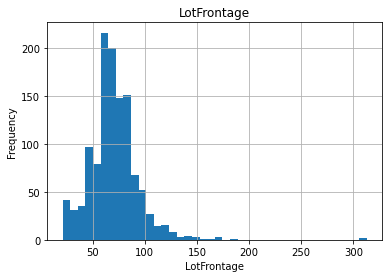

In [3]:
lot_frontage = df_train['LotFrontage']

plt.hist(lot_frontage, 40)
plt.xlabel('LotFrontage')
plt.ylabel('Frequency')
plt.title('LotFrontage')
plt.grid(True)
plt.show()

## Categorical features
### 1. Street
### 2. Alley
### 3. LotShape

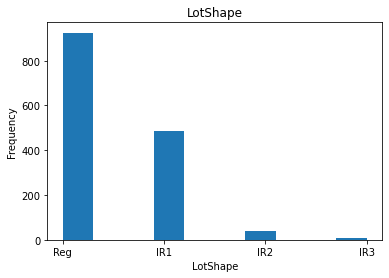

In [4]:
lot_shape = df_train['LotShape']

plt.hist(lot_shape)
plt.xlabel('LotShape')
plt.ylabel('Frequency')
plt.title('LotShape')
plt.show()

# 3. Pre-processing

### Process numerical data first
- Separate the numerical data from the categorical data to be able to noramlize the values
- Remove irrelevant numberical columns for training such as 'Id', 'MoSold' because they are not correlated with SalePrice
- Remove 'SalePrice' because it is the y-value that we will need to use later

After testing, it seems numerical data is highly correlated with SalePrice so we choose to keep most numerical data.
We only keep certain categorical features such as 'Electrical' and 'Exterior1st' because they seem to be correlated with SalePrice.  Additionally, we only include a couple categorical features to reduce the noise of non-correlated categorical features.

In [5]:
# get numerical data
numerical_columns = [column for column in df_train.columns if df_train[column].dtype == 'int64' 
                     and column not in ['Id', 'MoSold']]
train = df_train[numerical_columns]

### Scale the numerical data 
- Scale the numerical data to be standardized with less variance.  Having less variance makes the data more accurate when contributed to the model.

In [6]:
# scale numerical data
X_train = pd.DataFrame(preprocessing.scale(train.iloc[:,:-1]))

### Handle empty values 
- Replace empty values with the mean for that column.  This ensures the rows with empty values are still able to contribute to the model with presumably accurate data (the mean).

In [7]:
# replace empty values
for column in X_train:
    X_train[column].fillna(value=X_train[column].mean(), inplace=True)

### Center the y-values
Since the distribution of y-values was not symmetric, use the log function to center the distribution to improve the accuracy of the model.  Having a centered distributed means that values are evenly spread out and the model can make more accurate predictions.

In [8]:
# center the y-values to make the distribution symmetric
y_train = np.log1p(train.iloc[:,-1:])

# 4. 
Features that should be one-hot encoded: 
- Electrical
- Exterior1st
    
These features should be one-hot encoded because they are non-binary, the number of categories is small enough (to reduce the overall dimensionality of the model), and they are not ordinal.  Electrical is a foundational aspect of a house and exterior contributes greatly to the appearance of a house which is why these features have a greater impact on the sale price.  We only choose these two categorical features to reduce the noise the remaining categorical features would create in our model.

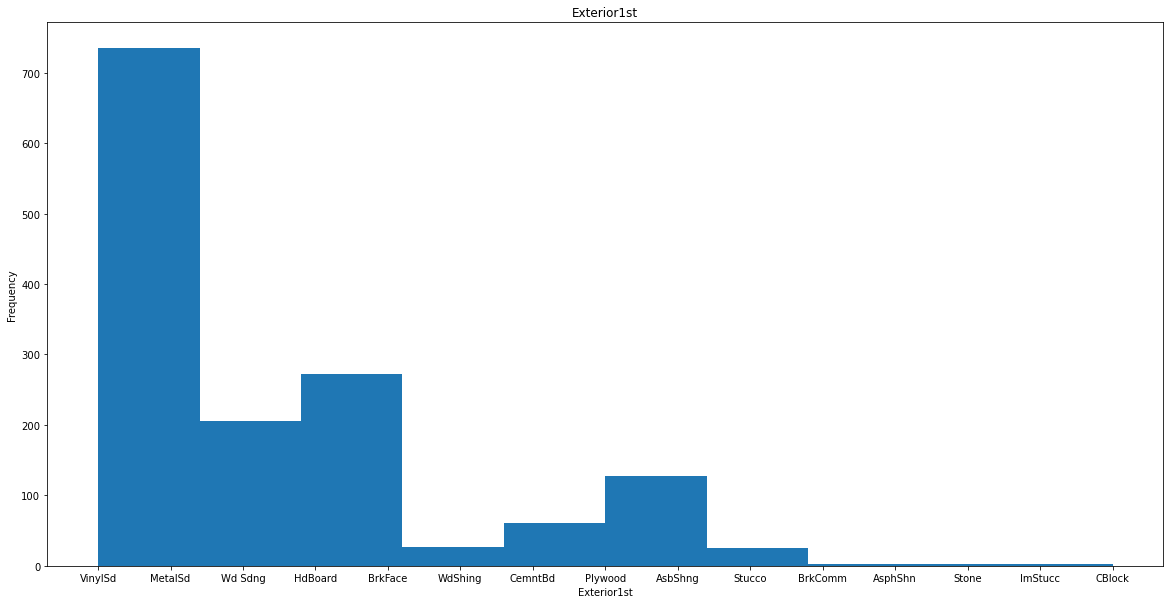

In [9]:
exterior = df_train['Exterior1st']

plt.rcParams["figure.figsize"] = (20,10)
plt.hist(exterior)
plt.xlabel('Exterior1st')
plt.ylabel('Frequency')
plt.title('Exterior1st')
plt.show()

In [10]:
# one-hot encode training categorical features
categorical_columns = ['Electrical', 'Exterior1st']
categorical_data = df_train[categorical_columns]
categorical_data = pd.get_dummies(categorical_data)

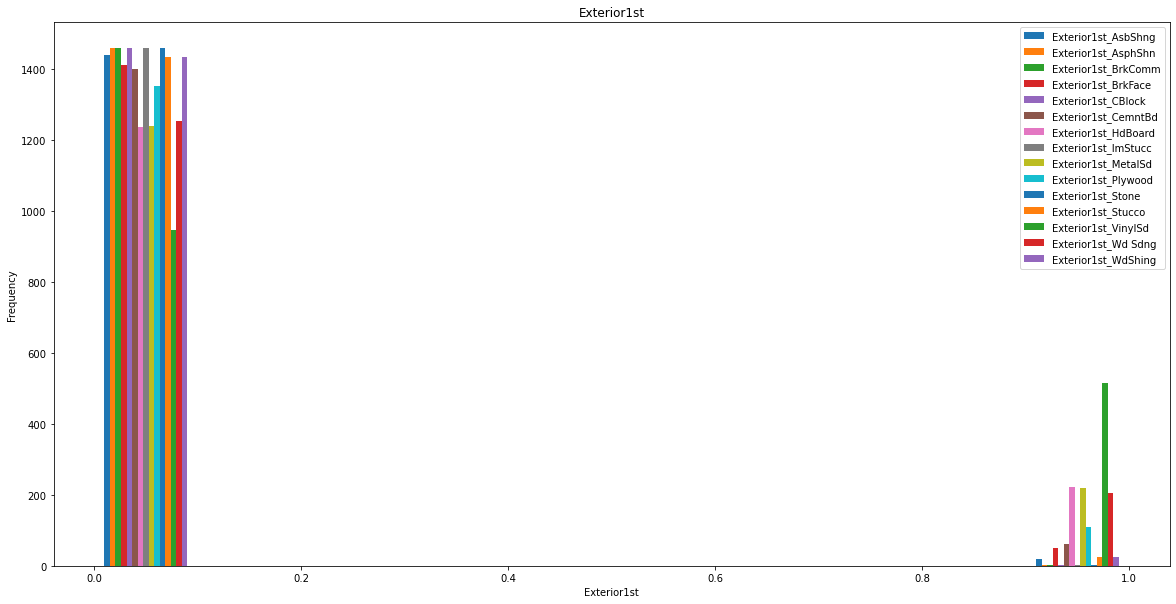

In [11]:
exterior_cols = [col for col in categorical_data if col.startswith('Exterior1st')]
exterior = categorical_data[exterior_cols]

plt.rcParams["figure.figsize"] = (20,10)
plt.hist(exterior)
plt.xlabel('Exterior1st')
plt.ylabel('Frequency')
plt.title('Exterior1st')
plt.legend(exterior_cols)
plt.show()

# 5. OLS

Descriptions of why certain features were kept and others discarded are included above in 3. and 4.

In [12]:
# combine categorical and numerical data
X_train = pd.concat([X_train, categorical_data], axis=1)

# add a column of ones
# X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

# calculate using OLS
theta_best = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
y_pred = X_train.dot(theta_best)

### MSE

In [13]:
print(mean_squared_error(y_train, y_pred))

0.18460377477634707


### R**2

In [14]:
print(r2_score(y_train, y_pred))

-0.15775021486615115


# 6. Test

In [15]:
# get numerical data
test = df_test[[col for col in numerical_columns if col != 'SalePrice']]

# scale numerical data
X_test = pd.DataFrame(preprocessing.scale(test))

# replace empty values
for column in X_test:
    X_test[column].fillna(value=X_test[column].mean(), inplace=True)
    
# one-hot encode testing categorical features
test_categorical_data = df_test[categorical_columns]
test_categorical_data = pd.get_dummies(test_categorical_data)

# add missing one-hot encoding columns from the training set
for col in categorical_data.columns:
    if col not in test_categorical_data:
        test_categorical_data[col] = 0

# combine categorical and numerical data
X_test = pd.concat([X_test, test_categorical_data], axis=1)

# predict (make sure to undo the log operation to map back onto the original space of y-values)
y_test = np.expm1(X_test.dot(theta_best))

y_test_final = pd.DataFrame(data = y_test.to_numpy(), index = df_test['Id'], columns = ['SalePrice'])

In [16]:
# create CSV with predictions
y_test_final.to_csv('house-prices-advanced-regression-techniques/predictions.csv')